In [15]:
%matplotlib inline

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scripts.pdf_parser_class import PDFparser

In [17]:
PDF = "../../task_description/examples/GFS 5760519.pdf"

In [18]:
my_parser = PDFparser()
df_marked = my_parser.get_rows_marked(PDF)

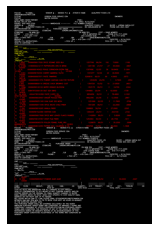

In [19]:
longest_str = df_marked.loc[df_marked[0].str.len().idxmax()][0]
mrgn = 50
font_scale = .35
color = (255, 255, 255)
thickness = 1
font = cv2.FONT_HERSHEY_SIMPLEX
line_type = cv2.LINE_AA

(w, h), baseline = cv2.getTextSize(longest_str,
                                   font,
                                   font_scale,
                                   thickness)

line_height = h + baseline

image = np.zeros((len(df_marked) * line_height + mrgn * 2,
                  w + mrgn * 2,
                  3), dtype="uint8")

x, y0 = (mrgn, mrgn)
for i in range(len(df_marked)):
    line = df_marked.loc[i, 0]
    y = y0 + i * line_height
    if df_marked.loc[i, "mark"] == "tbl_row":
        cv2.putText(image,
                    line,
                    (x, y),
                    font,
                    font_scale,
                    (255, 0, 0),
                    thickness,
                    line_type)
    elif df_marked.loc[i, "mark"] == "tbl_hdr":
        cv2.putText(image,
                    line,
                    (x, y),
                    font,
                    font_scale,
                    (255, 255, 0),
                    thickness,
                    line_type)
    else:
        cv2.putText(image,
                    line,
                    (x, y),
                    font,
                    font_scale,
                    (255, 255, 255),
                    thickness,
                    line_type)
        
    
# plt.spines["top"].set_visible(False)
# plt.spines["bottom"].set_visible(False)
# plt.spines["right"].set_visible(False)
# plt.spines["left"].set_visible(False)    
plt.axis("off")
plt.imshow(image)
# cv2.imshow("Result Image", image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()